In [1]:
#import packages
import time
import requests
import sys
import pandas as pd
from Bio import AlignIO
from pymsaviz import MsaViz
import plotly.express as px

In [13]:
 #functions utilized

#requests function
def get_url(url, **kwargs):
    response = requests.get(url, **kwargs)
    if not response.ok:
        print(response.text)
        response.raise_for_status()
        sys.exit()

    return response


#check the status of the alignment job
def status_check():
    if job_status.text == 'RUNNING' or job_status.text == 'QUEUED':
        print(job_status.text)
        return True
    else:
        print('FINISHED')
        return False


#show the alignment once job has completed
def show_alignment():
    query_alignment = get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/result/{job_id}/aln-clustal_num")
    print(query_alignment.text)
    
    
def aln_site_identity_df(aln, characters="ACDEFGHIKLMNPQRSTVWY"):
  aln_rows = aln.get_alignment_length()
  comp_dict = {char:[0]*aln_rows for char in characters}
  for record in aln:
    seq = record.seq
    for aaPos in range(len(seq)):
      aa = seq[aaPos]
      if aa in characters:
          comp_dict[aa][aaPos] += 1
                
  return pd.DataFrame.from_dict(comp_dict)


def aln_site_conservation_df(aln):
    aln_rows = aln.get_alignment_length()
    comp_dict = {char: [0] * aln_rows for char in aa_list}
    for record in aln:
        seq = record.seq
        for aa_pos in range(len(seq)):
            aa = seq[aa_pos]
            if aa in aa_list[0]:
                comp_dict['RHK'][aa_pos] += 1
            elif aa in aa_list[1]:
                comp_dict['DE'][aa_pos] += 1
            elif aa in aa_list[2]:
                comp_dict['STNQ'][aa_pos] += 1
            elif aa in aa_list[3]:
                comp_dict['AVILMNFYW'][aa_pos] += 1
            elif aa in aa_list[4]:
                comp_dict['CGP'][aa_pos] += 1
                
    return pd.DataFrame.from_dict(comp_dict)

In [3]:
#constants
UNIPROT_ENDPOINT = 'https://rest.uniprot.org'
QUERY = input("Enter the gene name").lower()
EXPECTED_LENGTH = int(input("Enter the expected length of the protein"))
MIN_SEQ_LENGTH = EXPECTED_LENGTH - (EXPECTED_LENGTH * 0.05)

In [4]:
#read and convert taxonomy csv to a dictionary
df = pd.read_csv('species_dataset.csv',
                 usecols=['Taxon Id', 'Common name', 'Scientific name'])

result = df.to_dict(orient='records')

In [5]:
#create new dictionary of only scientific name and taxon ID
taxon_id_list = []
scientific_name_list = []

for ids in result:
    for key in ids:
        if key == 'Taxon Id':
            taxon_id = ids[key]
            taxon_id_list.append(taxon_id)
        if key == 'Scientific name':
            scientific_name = ids[key]
            scientific_name_list.append(scientific_name)

taxonomy_dict = dict(zip(scientific_name_list, taxon_id_list))

In [6]:
#create an accession list which will be used to query and retrieve sequences
accession_list = []
accession_dict = {}

for tax_id in taxonomy_dict.values():
    r = get_url(f"{UNIPROT_ENDPOINT}/uniprotkb/search?query={QUERY} AND (taxonomy_id: {tax_id})")
    data = r.json()
    # n_results = len(data["results"])
    # print(f"Number of results: {n_results}\n")
    for sequences in data['results']:
        protein_existence = sequences['proteinExistence']

        if (protein_existence == '1: Evidence at protein level' or
                protein_existence == '2: Evidence at transcript level' or
                protein_existence == '3: Inferred from homology'):

            try:
                seq_len = int(sequences['sequence']['length'])
                gene_name = (sequences['genes'][0]['geneName']['value']).lower()
                
                if  gene_name == QUERY:
            
                    if seq_len >= MIN_SEQ_LENGTH:
                        accession_id = sequences['primaryAccession']
                        sequence = sequences['sequence']
                        accession_dict[accession_id] = sequence
                        accession_list.append(sequences['primaryAccession'])
                        break
            except KeyError:
                break
print(accession_list)

['A0A2K5Q6F0', 'A0A2K6KCF8', 'G1P2E6', 'A0A803VYW1', 'A0A0D9RH05', 'I3MTK1', 'A0A2K5E3X9', 'H0XPH1', 'F6TR95', 'K7FTC9', 'H3AJB2', 'A0A8B9L0X7', 'A0A669F1A1', 'U6C7D3', 'A0A6I8QSM5', 'A0A8V1ADL9', 'A0A7N4PNY0', 'F7FPU1', 'A0A2K5KRD2', 'A0A5F8A0I7', 'A0A2K6C3U7', 'A0A0A0MWX2', 'G3S0U3', 'H2QEW1', 'A0A2J8R3R0', 'P03971', 'A0A8C0N2S3', 'A0A7N5KEB7', 'A0A8U0T6R4', 'A0A2I2V0G5', 'F2YMM5', 'P79295', 'P03972', 'T1SHH2', 'P27106', 'P49000', 'H0W8G2']


In [7]:
#join the list and create a fasta
joined = ','.join(accession_list)
align_response = get_url(f"{UNIPROT_ENDPOINT}/uniprotkb/accessions?accessions={joined}&format=fasta")
fasta = align_response.text
with open(f'{QUERY}_unaligned.fasta', 'w+') as file:
    file.writelines(fasta)
print(fasta)

>tr|A0A2K5Q6F0|A0A2K5Q6F0_CEBIM Muellerian-inhibiting factor OS=Cebus imitator OX=2715852 GN=AMH PE=3 SV=1
MQGPPLAHLALVLSALGALLGTETLGVEEPAVATGGLIFGEDVDWPPGSPQEPLCLVALG
GDSNGSSTPLRVVGTLRGYEQAFLGAVQQARWGPQDLATFGVCSPGDRQAALLSLQRLGA
WLRGPGGQRLVVLHLEEVTWEPTPSLRFQEPPPGGAGPPELALLVLYPGPGPEVTVTRAG
LLGSQSLCPSRDTHYLVLAVDRPAGAWRGSGLALTLQPRGEGAPLSTARLKALLFGDDRR
CFTRMTPALLLLPRSEPAPLPAHGQLDTVPLPPPRPSAELEESPPSADPFLETLTRLVRA
LRGSPARASAPRLALDPGALAGFPQGLVNLSDPAALERLLDGEEPLLLLLPPAAATVSGD
PAPLQEPTSAPWATALVRRVTAELQAAAAELRGLPGLPPAAAPLLERLLALCPGGPGGSL
RALLLLKALQGLRAEWRRWDPRGLGRAQRSAGATAANGPCALHELSVDLRAERSVLIPET
YQANNCQGACGWPQSDRNPRYGNHVVLLLKMQARGAALARPPCCVPTAYAGKLLISLSEE
RISAHHVPNMVATECGCR
>tr|A0A2K6KCF8|A0A2K6KCF8_RHIBE Muellerian-inhibiting factor OS=Rhinopithecus bieti OX=61621 GN=AMH PE=3 SV=1
MWDLPLTSLTLVLSALGVLLGTATLRAEEPAVGTGGLIFREDLDWPPGSPQEPLCLVALV
GDSNGSSIPLQVMGVLSAYERAFLGPCNLATFGVCTPGDRQAALPSLRRLGAWLQDPGGQ
RLVVLHLEEVTWEPTPSLRFQEPPHGGGDSLELALLVLYPGPGPEVPGGCMGAGLAKPPS
SRPELWSPQTLCPSRDTRYLALAVDRPAGAWR

In [8]:
#submit and monitor job status
response_alignment = requests.post("https://www.ebi.ac.uk/Tools/services/rest/clustalo/run", data={
    "email": "example@example.com",
    "iterations": 0,
    "outfmt": "clustal_num",
    "order": "aligned",
    "sequence": fasta
})

job_id = response_alignment.text
job_status = get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/status/{job_id}")

while status_check():
    job_status = get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/status/{job_id}")
    time.sleep(3)

RUNNING
RUNNING
RUNNING
RUNNING
FINISHED


In [9]:
#show alignment
show_alignment()

CLUSTAL O(1.2.4) multiple sequence alignment


tr|A0A8B9L0X7|A0A8B9L0X7_ASTMX      --------------------------M--GVQTGC-WLLLLLPV-AVVTGPL-HTAERKL	29
tr|A0A669F1A1|A0A669F1A1_ORENI      ------------------MLGLLVLYS--EALTLC-WTLQPAQD-PTVT-----------	27
tr|U6C7D3|U6C7D3_XENLA              -----------------MLPMLFFSYTGMGIARLRWWL-FLLPMMRHTLSSKSDTREAQE	42
tr|A0A6I8QSM5|A0A6I8QSM5_XENTR      --------------MTEMLPILFFNYTVMGIVSLGWWL-LMLPMMCLTLSSKSVPKVAKE	45
tr|F6TR95|F6TR95_MONDO              ------------------MKG-----------SLL-VLLLFLPGMLAVPREEPPEKRGRA	30
tr|A0A7N4PNY0|A0A7N4PNY0_SARHA      ------------------MKG-----------SLL-GLLLLLPAMFAVLRGAPPKKG-QS	29
sp|P27106|MIS_MOUSE                 ------------------MQG-----------PHLSPLVLLLATMGAVLQPEAV--E---	26
sp|P49000|MIS_RAT                   ------------------MQG-----------PHLSLLLLLLATMGAVLQADTV--E---	26
tr|I3MTK1|I3MTK1_ICTTR              ------------------MQG-----------PPFLSQLALVVAMGTVLRVEISRGE---	28
tr|H0W8G2|H0W8G2_CAVPO              -----------------

In [10]:
#create text file
alignment = (get_url(f"https://www.ebi.ac.uk/Tools/services/rest/clustalo/result/{job_id}/aln-clustal_num")).text

with open(f'{QUERY}_aligned_MSA.aln', 'w+') as file:
    file.writelines(alignment)

In [11]:
#turn MSA file into fasta file using BioPython
def convert_clustal_to_fasta(input_file, output_file):
    # Parse the CLUSTAL file and read the alignment
    clustal_alignment = AlignIO.read(input_file, "clustal")

    # Write the alignment in FASTA format
    with open(output_file, "w") as fasta_file:
        AlignIO.write(clustal_alignment, fasta_file, "fasta")

if __name__ == "__main__":
    input_clustal_file = f"{QUERY}_aligned_MSA.aln"
    output_fasta_file = f"{QUERY}_aligned_fasta.fasta"

    convert_clustal_to_fasta(input_clustal_file, output_fasta_file)

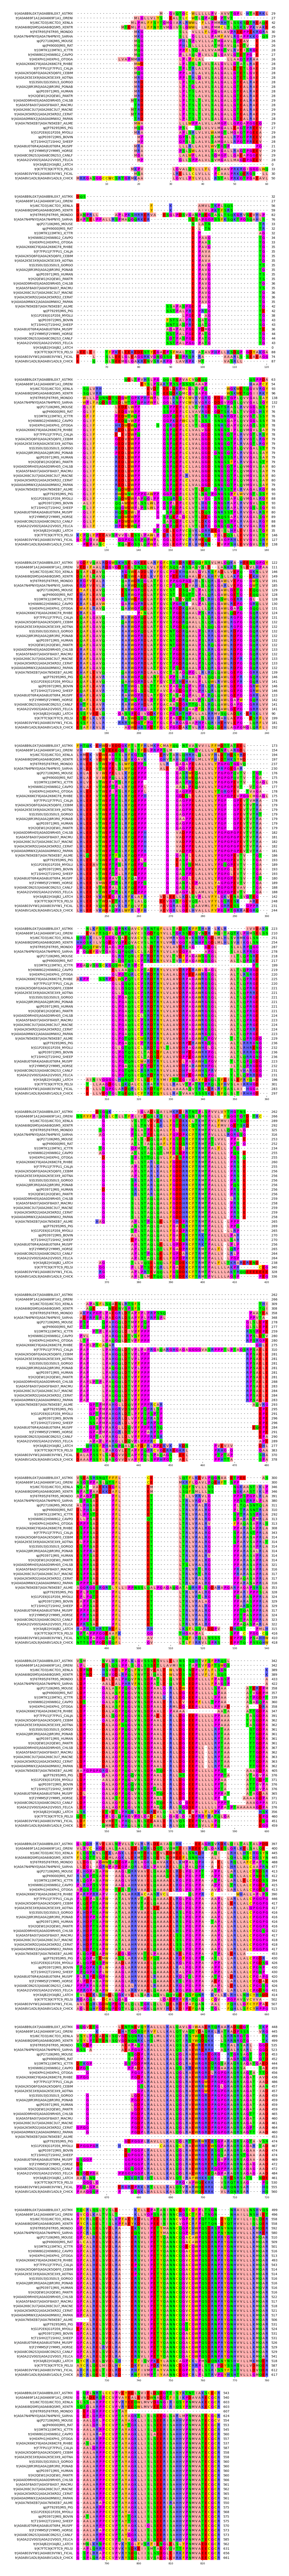

In [12]:
#Generate multiple sequence alignment image
msa_file = open(f"{QUERY}_aligned_fasta.fasta")
mv = MsaViz(msa_file, wrap_length=60, show_count=True)
mv.savefig(f"{QUERY}.png")

In [ ]:
#Load alignment data
alignment_file = f"{QUERY}_aligned_MSA.aln"
query_align = AlignIO.read(alignment_file, "clustal")
print(query_align)

In [ ]:
#Create alignment data frame
alignment_site_identity_df = aln_site_identity_df(query_align)
alignment_site_identity_df

In [ ]:
#Normalize data frame
normalized_freq_df = alignment_site_identity_df.div(alignment_site_identity_df.sum(axis=1), axis=0)
normalized_freq_df

In [ ]:
#Plot sequence identity 
fig = px.bar(normalized_freq_df, y=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'], title="identity")

fig.update_layout(
    xaxis = dict(
        rangeslider = dict(
            visible=True
        )
    )
)

fig.show()

In [ ]:
#Generate and plot amino acid conservation
aa_list = ['RHK', 'DE', 'STNQ', 'AVILMNFYW', 'CGP']

#create alignment data frame 
alignment_site_identity_df = aln_site_conservation_df(query_alignment)
alignment_site_identity_df

In [ ]:
#Normalizer the data frame
normalized_conservation_freq_df = alignment_site_identity_df.div(
    alignment_site_identity_df.sum(axis=1), axis=0)
normalized_conservation_freq_df

In [ ]:
#Plot percent conservation 
fig = px.bar(normalized_conservation_freq_df, 
             y=['RHK', 'DE', 'STNQ', 'AVILMNFYW', 'CGP'], title="conservation")

fig.update_layout(
    xaxis = dict(
        rangeslider = dict(
            visible=True
        )
    )
)


fig.show()